In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 載入資料
# df = pd.read_csv("female_stroke_data.csv")  # 請換成你的檔案路徑
df = pd.read_csv("male_stroke_data.csv")  # 請換成你的檔案路徑

# 分離 features & labels
X = df.drop(columns=["Second_Stroke"])  # 假設 "target" 是標籤
y = df["Second_Stroke"]

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 標準化（對 DCNN 來說很重要）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Data preprocessing done!")

✅ Data preprocessing done!


In [4]:
!pip3 install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15077 sha256=3268404a005f199bf438707fce1aa425f7c4f4440ba55b98730467169bb5debb
  Stored in directory: /root/.cache/pip/wheels/07/e6/86/f23164d12c3134966614102db8e7956ab359faf7ffd78703ce
Successfully built func-timeout


 The best solution found:
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]

 Objective function:
 -0.9508196721311476


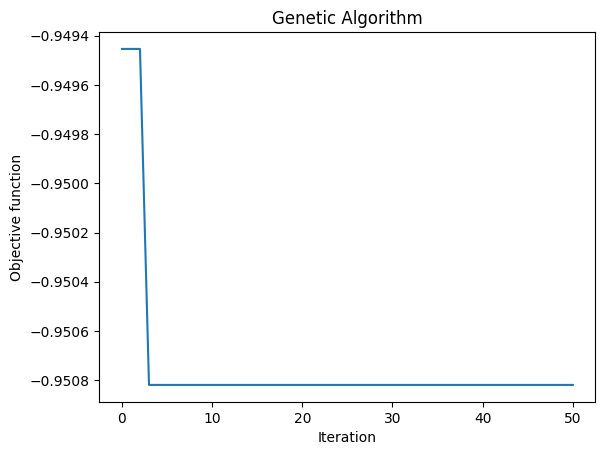

✅ Feature selection done!


In [17]:
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 適應度函數（用 RF 來評估特徵組合）
def fitness_function(selected_features):
    selected_features = selected_features.astype(bool)
    X_selected = X_train[:, selected_features]

    model = RandomForestClassifier()
    scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')

    return -scores.mean()  # GA 會最小化這個值，所以取負值


from sklearn.feature_selection import VarianceThreshold

# 設定方差閾值（0表示完全相同的特徵將會被刪除）
selector = VarianceThreshold(threshold=0)
X_train_filtered = selector.fit_transform(X_train)
X_test_filtered = selector.transform(X_test)



# 設定 GA 參數
var_bound = np.array([[0, 1]] * X_train.shape[1])  # 每個特徵 0 or 1
algorithm_param = {'max_num_iteration': 50, 'population_size': 20, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}

# 進行 GA
model = ga(function=fitness_function, dimension=X_train.shape[1], variable_type='int', variable_boundaries=var_bound, algorithm_parameters=algorithm_param)
model.run()

# 取得最佳特徵組合
best_features = model.output_dict['variable'].astype(bool)
X_train_selected = X_train[:, best_features]
X_test_selected = X_test[:, best_features]

print("✅ Feature selection done!")

In [18]:
from imblearn.over_sampling import SMOTE

# 使用 SMOTE 增強數據
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print("✅ Data augmentation done! New class distribution:", np.bincount(y_train_balanced))

✅ Data augmentation done! New class distribution: [695 695]


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 建立 DCNN 模型
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # 二元分類
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
history = model.fit(X_train_balanced, y_train_balanced, validation_data=(X_test_selected, y_test), epochs=50, batch_size=32)

print("✅ Model training done!")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5532 - loss: 0.8629 - val_accuracy: 0.4402 - val_loss: 0.6960
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6752 - loss: 0.6362 - val_accuracy: 0.3098 - val_loss: 0.7605
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7037 - loss: 0.5822 - val_accuracy: 0.3533 - val_loss: 0.7987
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7379 - loss: 0.5294 - val_accuracy: 0.3315 - val_loss: 0.8191
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7399 - loss: 0.5290 - val_accuracy: 0.4348 - val_loss: 0.7852
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7331 - loss: 0.5343 - val_accuracy: 0.4728 - val_loss: 0.7420
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7426 - loss: 0.5340 - val_accuracy: 0.5435 - val_loss: 0.6785
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7534 - loss: 0.5031 - val_accuracy: 0.5761 - val_loss: 0.6730
Ep

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# 預測
y_pred = (model.predict(X_test_selected) > 0.5).astype(int)

# 評估結果
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print("✅ Model evaluation done!")

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix:
 [[142  33]
 [  8   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.81      0.87       175
           1       0.03      0.11      0.05         9

    accuracy                           0.78       184
   macro avg       0.49      0.46      0.46       184
weighted avg       0.90      0.78      0.83       184

✅ Model evaluation done!
